<a href="https://colab.research.google.com/github/Furkanpusher/U-NET/blob/main/base_model_with_coorAtt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat May  3 13:36:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   64C    P0             30W /   72W |    6131MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import load


# .npz dosyasını yükle
data = load('/content/drive/MyDrive/gopro_dataset.npz')

# Verileri ayrı değişkenlere aktar
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

# Kontrol amaçlı şekilleri yazdır
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2103, 640, 640, 3)
y_train shape: (2103, 640, 640, 3)
x_test shape: (1111, 640, 640, 3)
y_test shape: (1111, 640, 640, 3)


In [ ]:
x_train = torch.tensor(data=x_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (B, C, H, W)
y_train = torch.tensor(data=y_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
x_test = torch.tensor(data=x_test, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_test = torch.tensor(data=y_test, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Özel veri seti sınıfı (boyutlandırma için)
class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)  # Aynı transform’ü hem x hem y’ye uygula
        return x, y

# Transform: Sadece 640x640 boyutlandırma
transform = transforms.Resize((640, 640))

# Veri setlerini oluştur
train_dataset = CustomDataset(x_train, y_train, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)

# DataLoader’lar
batch_size = 8  # 640x640 görüntüler için GPU belleğine uygun
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
assert x_train.shape == (2103, 3, 640, 640), f"x_train boyutu hatalı: {x_train.shape}"
assert y_train.shape == (2103, 3, 640, 640), f"y_train boyutu hatalı: {y_train.shape}"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from unet_parts import DownSample, UpSample, DoubleConv
from COOR_ATT import CoordAtt

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, bilinear=False):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        # Encoder (downsampling path)
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # CoordAtt modülleri (her skip connection için)
        self.coordatt_1 = CoordAtt(64, 64)
        self.coordatt_2 = CoordAtt(128, 128)
        self.coordatt_3 = CoordAtt(256, 256)
        self.coordatt_4 = CoordAtt(512, 512)

        # Bottleneck
        self.bottle_neck = DoubleConv(512, 1024)

        # Decoder (upsampling path)
        self.up_convolution_1 = UpSample(1024, 512, 512)
        self.up_convolution_2 = UpSample(512, 256, 256)
        self.up_convolution_3 = UpSample(256, 128, 128)
        self.up_convolution_4 = UpSample(128, 64, 64)

        # Final output layer
        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        down_1, p1 = self.down_convolution_1(x)
        down_1 = self.coordatt_1(down_1)
        down_2, p2 = self.down_convolution_2(p1)
        down_2 = self.coordatt_2(down_2)
        down_3, p3 = self.down_convolution_3(p2)
        down_3 = self.coordatt_3(down_3)
        down_4, p4 = self.down_convolution_4(p3)
        down_4 = self.coordatt_4(down_4)

        # Bottleneck
        b = self.bottle_neck(p4)

        # Decoder path with skip connections
        up_1 = self.up_convolution_1(b, down_4)
        if isinstance(up_1, tuple):
            up_1 = up_1[0]

        up_2 = self.up_convolution_2(up_1, down_3)
        if isinstance(up_2, tuple):
            up_2 = up_2[0]

        up_3 = self.up_convolution_3(up_2, down_2)
        if isinstance(up_3, tuple):
            up_3 = up_3[0]

        up_4 = self.up_convolution_4(up_3, down_1)
        if isinstance(up_4, tuple):
            up_4 = up_4[0]

        logits = self.out(up_4)
        return logits

# Örnek kullanım
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=3, num_classes=3).to(device)
    input_tensor = torch.rand(1, 3, 640, 640).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        print(f"Çıkış boyutu: {output.shape}")

    summary(model, input_size=(3, 640, 640), device=str(device))

 # 31,081,019 parametre

Çıkış boyutu: torch.Size([1, 3, 640, 640])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 640, 640]           1,792
       BatchNorm2d-2         [-1, 64, 640, 640]             128
              ReLU-3         [-1, 64, 640, 640]               0
            Conv2d-4         [-1, 64, 640, 640]          36,928
       BatchNorm2d-5         [-1, 64, 640, 640]             128
              ReLU-6         [-1, 64, 640, 640]               0
        DoubleConv-7         [-1, 64, 640, 640]               0
         MaxPool2d-8         [-1, 64, 320, 320]               0
        DownSample-9  [[-1, 64, 640, 640], [-1, 64, 320, 320]]               0
AdaptiveAvgPool2d-10           [-1, 64, 640, 1]               0
AdaptiveAvgPool2d-11           [-1, 64, 1, 640]               0
           Conv2d-12           [-1, 8, 1280, 1]             520
      BatchNorm2d-13           [-1, 8, 1280, 

In [ ]:
!pip install pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import MS_SSIM
import os
import matplotlib.pyplot as plt  # Grafik için gerekli

# Loss fonksiyonları
mse_loss = nn.MSELoss()
ms_ssim_module = MS_SSIM(data_range=1.0, size_average=True, channel=3)

def combined_loss(pred, target, lambda_mse=0.4, lambda_msssim=0.6):
    mse = mse_loss(pred, target)
    ms_ssim_loss = 1 - ms_ssim_module(pred, target)
    return lambda_mse * mse + lambda_msssim * ms_ssim_loss

def train_model(model, train_loader, num_epochs=32, lr=1e-4, device='cuda', save_dir='weights_with_coordatt'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = combined_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        loss_history.append(avg_loss)
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_loss:.6f}")

        # Modeli kaydet
        torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch+1}.pt"))

    print("Eğitim tamamlandı.")

    # 🔽 Eğitim sonunda Loss grafiğini çiz
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), loss_history, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'train_loss_plot.png'))  # Grafik dosyasını kaydet
    plt.show()

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, num_classes=3).to(device)
model = train_model(model, train_loader, num_epochs=50, lr=1e-4, device=device, save_dir='weights_with_coordatt')


[Epoch 1/50] Train Loss: 0.123578
[Epoch 2/50] Train Loss: 0.069909
[Epoch 3/50] Train Loss: 0.067491
[Epoch 4/50] Train Loss: 0.065782
[Epoch 5/50] Train Loss: 0.064722
[Epoch 6/50] Train Loss: 0.063564
[Epoch 7/50] Train Loss: 0.062306
[Epoch 8/50] Train Loss: 0.061442
[Epoch 9/50] Train Loss: 0.060425
[Epoch 10/50] Train Loss: 0.059458
[Epoch 11/50] Train Loss: 0.058501
[Epoch 12/50] Train Loss: 0.057664
[Epoch 13/50] Train Loss: 0.056627
[Epoch 14/50] Train Loss: 0.055524
[Epoch 15/50] Train Loss: 0.054972
[Epoch 16/50] Train Loss: 0.053758
[Epoch 17/50] Train Loss: 0.052577
[Epoch 18/50] Train Loss: 0.051977
[Epoch 19/50] Train Loss: 0.051374
[Epoch 20/50] Train Loss: 0.050407
[Epoch 21/50] Train Loss: 0.049693
[Epoch 22/50] Train Loss: 0.048829
[Epoch 23/50] Train Loss: 0.048168
[Epoch 24/50] Train Loss: 0.047262
[Epoch 25/50] Train Loss: 0.046911
[Epoch 26/50] Train Loss: 0.046241
[Epoch 27/50] Train Loss: 0.046005
[Epoch 28/50] Train Loss: 0.044920
[Epoch 29/50] Train Loss: 0.0

KeyboardInterrupt: 

In [ ]:
import torch
import os

# Path to the existing model file
input_file = '/content/weights_with_coordatt/base_model_with_cooratt_epoch_36.pt'

# Checking if the file exists
if not os.path.exists(input_file):
    print(f"Error: The file {input_file} does not exist in the current directory.")
    exit(1)

try:
    # Load the model
    model_data = torch.load(input_file)

    # Save the model (you can specify a new path or use the same to overwrite)
    save_path = '/content/drive/MyDrive/Base_model_with_Cooratt_36_epoch.pt'  # You can change this to your preferred filename
    torch.save(model_data, save_path)

    print(f"Model successfully loaded from {input_file} and saved to {save_path}")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Model successfully loaded from /content/weights_with_coordatt/base_model_with_cooratt_epoch_36.pt and saved to /content/drive/MyDrive/Base_model_with_Cooratt_36_epoch.pt


Testing: 100%|██████████| 139/139 [01:24<00:00,  1.65it/s]


Test MSE: 0.002574, Test MS-SSIM: 0.938271
Metrics visualization saved to /content/metrics_plot.png


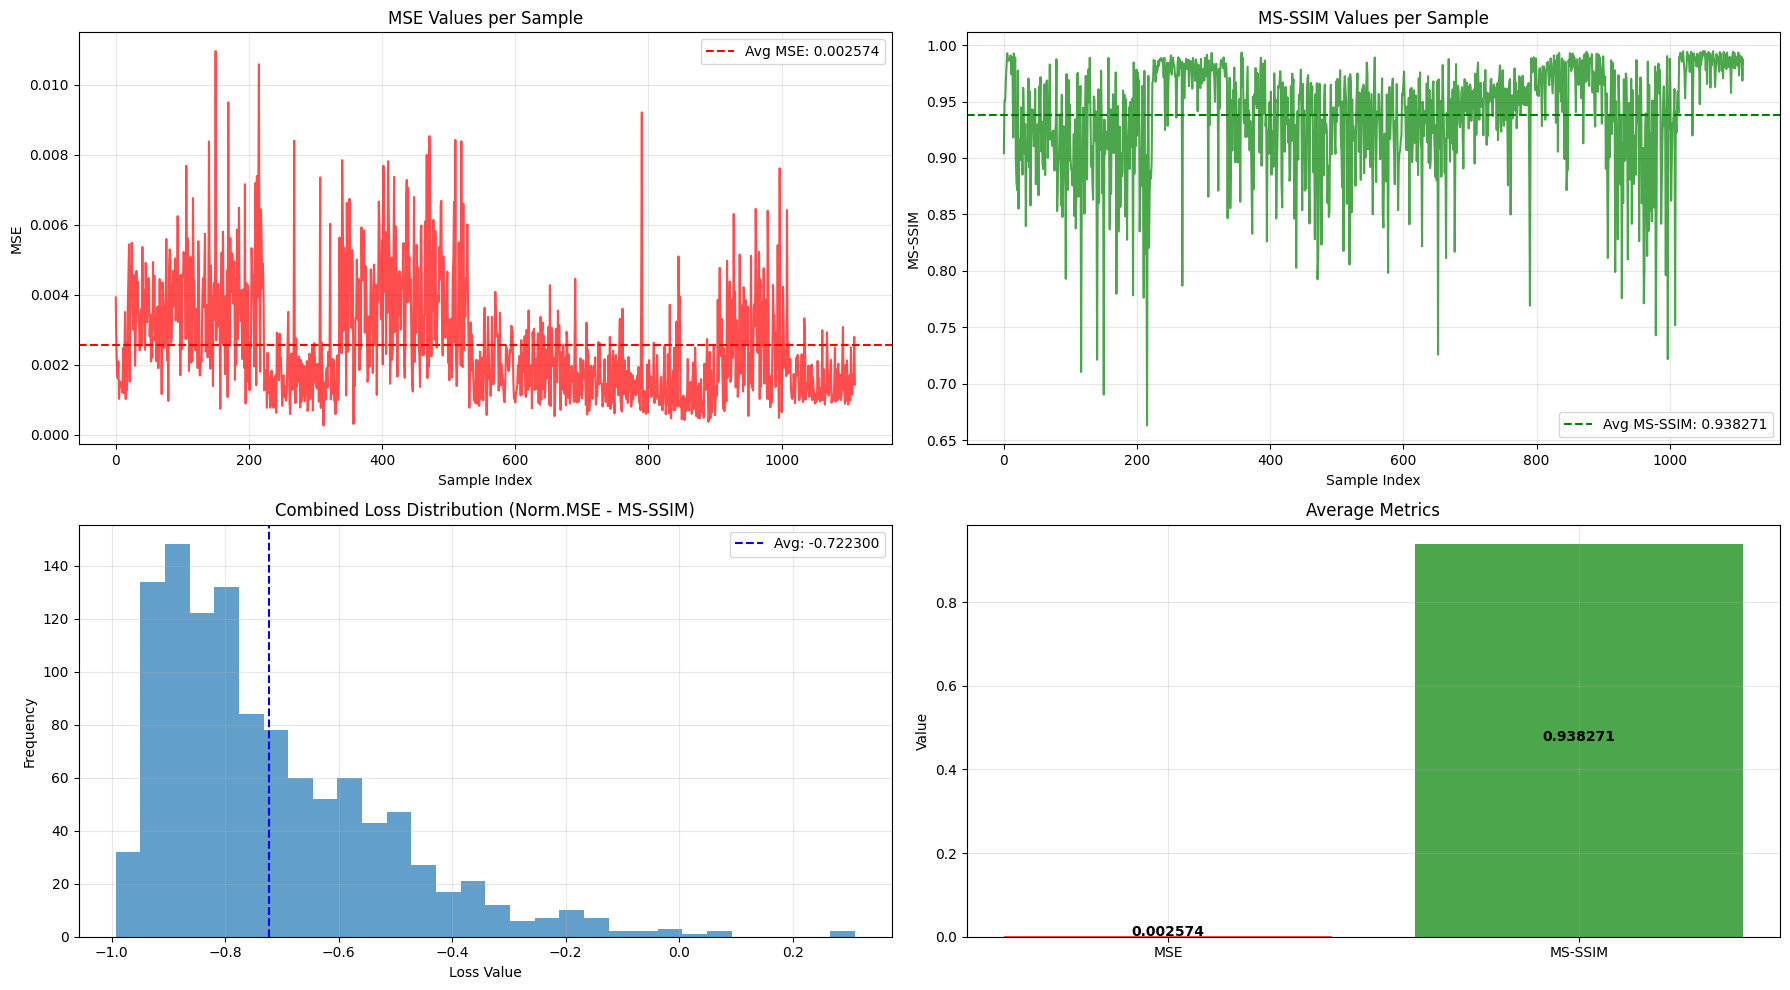

Sample visualization saved to /content/ornek_tahminler.png


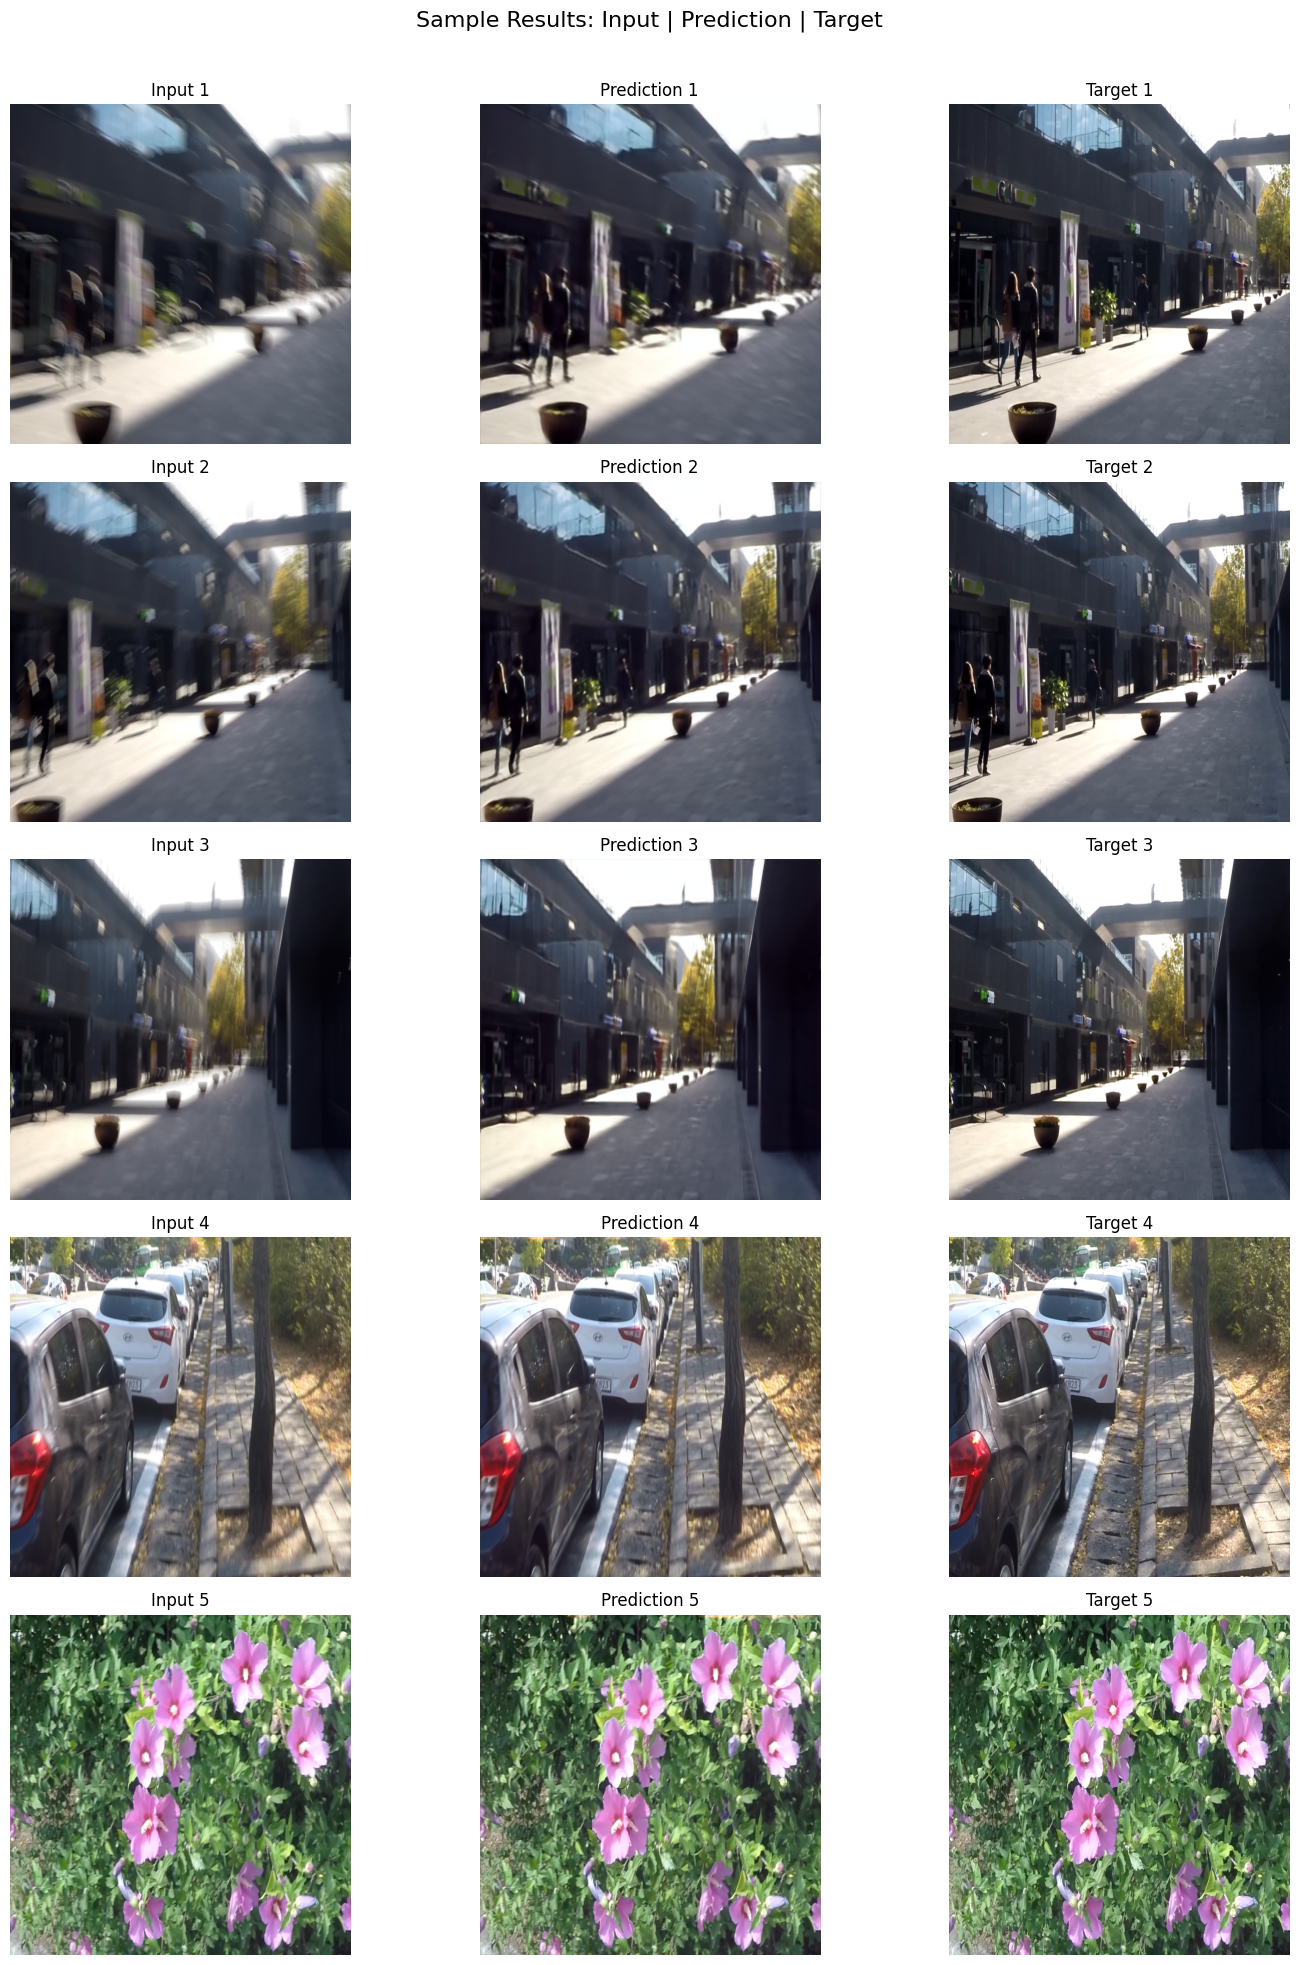

In [ ]:
import torch
import torch.nn as nn
from pytorch_msssim import MS_SSIM
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm

# Loss ve metrik fonksiyonları
mse_loss = nn.MSELoss()
ms_ssim_module = MS_SSIM(data_range=1.0, size_average=True, channel=3)

def compute_metrics(pred, target):
    mse = mse_loss(pred, target).item()
    ms_ssim = ms_ssim_module(pred, target).item()
    return mse, ms_ssim

def visualize_metrics(sample_metrics, avg_metrics, save_path=None):
    """
    Visualize metrics from testing.

    Args:
        sample_metrics: Dictionary with lists of MSE, MS-SSIM values for samples
        avg_metrics: Dictionary with average MSE, MS-SSIM values
        save_path: Path to save the visualization
    """
    fig = plt.figure(figsize=(18, 10))

    # Plot 1: Sample MSE values
    plt.subplot(2, 2, 1)
    plt.plot(sample_metrics['mse'], 'r-', alpha=0.7)
    plt.axhline(y=avg_metrics['mse'], color='r', linestyle='--', label=f'Avg MSE: {avg_metrics["mse"]:.6f}')
    plt.title('MSE Values per Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('MSE')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Sample MS-SSIM values
    plt.subplot(2, 2, 2)
    plt.plot(sample_metrics['ms_ssim'], 'g-', alpha=0.7)
    plt.axhline(y=avg_metrics['ms_ssim'], color='g', linestyle='--', label=f'Avg MS-SSIM: {avg_metrics["ms_ssim"]:.6f}')
    plt.title('MS-SSIM Values per Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('MS-SSIM')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 3: Combined Loss (MSE - MS_SSIM) distribution
    plt.subplot(2, 2, 3)
    # Normalizing MSE values to be in similar range as MS-SSIM
    normalized_mse = (np.array(sample_metrics['mse']) - min(sample_metrics['mse'])) / (max(sample_metrics['mse']) - min(sample_metrics['mse']))
    combined_loss = normalized_mse - np.array(sample_metrics['ms_ssim'])
    avg_combined_loss = np.mean(combined_loss)

    plt.hist(combined_loss, bins=30, alpha=0.7)
    plt.axvline(x=avg_combined_loss, color='b', linestyle='--', label=f'Avg: {avg_combined_loss:.6f}')
    plt.title('Combined Loss Distribution (Norm.MSE - MS-SSIM)')
    plt.xlabel('Loss Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 4: General metrics bar plot
    plt.subplot(2, 2, 4)
    metrics = ['MSE', 'MS-SSIM']
    values = [avg_metrics['mse'], avg_metrics['ms_ssim']]
    colors = ['red', 'green']

    plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.title('Average Metrics')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)

    # Add text annotations on each bar
    for i, v in enumerate(values):
        plt.text(i, v/2, f'{v:.6f}', ha='center', fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Metrics visualization saved to {save_path}")

    plt.show()

def visualize_samples(inputs, targets, outputs, num_samples=5, save_path=None):
    """
    Visualize sample inputs, targets, and outputs.

    Args:
        inputs: Batch of input images
        targets: Batch of target images
        outputs: Batch of output images
        num_samples: Number of samples to visualize
        save_path: Path to save the visualization
    """
    num_samples = min(num_samples, inputs.size(0))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    # Set the overall title
    fig.suptitle('Sample Results: Input | Prediction | Target', fontsize=16)

    for i in range(num_samples):
        # Input image
        inp_img = inputs[i].cpu().permute(1, 2, 0).numpy()
        inp_img = np.clip(inp_img, 0, 1)
        axes[i, 0].imshow(inp_img)
        axes[i, 0].set_title(f'Input {i+1}')
        axes[i, 0].axis('off')

        # Output image
        out_img = outputs[i].cpu().permute(1, 2, 0).detach().numpy()
        out_img = np.clip(out_img, 0, 1)
        axes[i, 1].imshow(out_img)
        axes[i, 1].set_title(f'Prediction {i+1}')
        axes[i, 1].axis('off')

        # Target image
        tgt_img = targets[i].cpu().permute(1, 2, 0).numpy()
        tgt_img = np.clip(tgt_img, 0, 1)
        axes[i, 2].imshow(tgt_img)
        axes[i, 2].set_title(f'Target {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the suptitle

    if save_path:
        plt.savefig(save_path)
        print(f"Sample visualization saved to {save_path}")

    plt.show()

def test_model(model, test_loader, device='cuda', save_path=None):
    model.eval()
    total_mse = 0.0
    total_ms_ssim = 0.0

    # Lists to store metrics for individual samples
    sample_mse = []
    sample_ms_ssim = []

    # Store a few samples for visualization
    sample_inputs = None
    sample_targets = None
    sample_outputs = None

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Compute metrics
            mse, ms_ssim = compute_metrics(outputs, targets)

            # Add batch metrics to total
            batch_size = inputs.size(0)
            total_mse += mse * batch_size
            total_ms_ssim += ms_ssim * batch_size

            # Store individual sample metrics
            batch_sample_mse = [(mse_loss(outputs[i:i+1], targets[i:i+1])).item() for i in range(batch_size)]
            batch_sample_ms_ssim = [ms_ssim_module(outputs[i:i+1], targets[i:i+1]).item() for i in range(batch_size)]

            sample_mse.extend(batch_sample_mse)
            sample_ms_ssim.extend(batch_sample_ms_ssim)

            # Store samples for visualization (first batch only)
            if sample_inputs is None:
                sample_inputs = inputs[:10].clone()  # Store first 5 samples
                sample_targets = targets[:10].clone()
                sample_outputs = outputs[:].clone()

    # Calculate average metrics
    avg_mse = total_mse / len(test_loader.dataset)
    avg_ms_ssim = total_ms_ssim / len(test_loader.dataset)

    print(f"Test MSE: {avg_mse:.6f}, Test MS-SSIM: {avg_ms_ssim:.6f}")

    # Visualize metrics
    sample_metrics = {
        'mse': sample_mse,
        'ms_ssim': sample_ms_ssim
    }

    avg_metrics = {
        'mse': avg_mse,
        'ms_ssim': avg_ms_ssim
    }

    # Create visualization directory if it doesn't exist
    import os
    if save_path:
        os.makedirs(save_path, exist_ok=True)

    # Visualize metrics
    metrics_save_path = os.path.join(save_path, '/content/metrics_plot.png') if save_path else None
    visualize_metrics(sample_metrics, avg_metrics, save_path=metrics_save_path)

    # Visualize sample predictions
    samples_save_path = os.path.join(save_path, '/content/ornek_tahminler.png') if save_path else None
    visualize_samples(sample_inputs, sample_targets, sample_outputs, save_path=samples_save_path)

    return avg_metrics

# Kullanım örneği
if __name__ == "__main__":
    # from model import UNet
    # from dataloader import test_loader

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=3, num_classes=3).to(device)
    model.load_state_dict(torch.load('/content/weights_with_coordatt/base_model_with_cooratt_epoch_36.pt'))

    # Sonuçları kaydetmek için klasör yolu (isteğe bağlı)
    visualization_path = "./test_results"

    # Test ve görselleştirme
    test_model(model, test_loader, device=device, save_path=visualization_path)

# 27 EPOCHDAN SONRA OVERFITTING BAŞLIYOR OLABİLİR

#  Ulaşılan değerler: SSIM: 0.7881 | PSNR: 24.14dB
#    Hedef değerler:    SSIM: 0.9300 | PSNR: 30.00dB

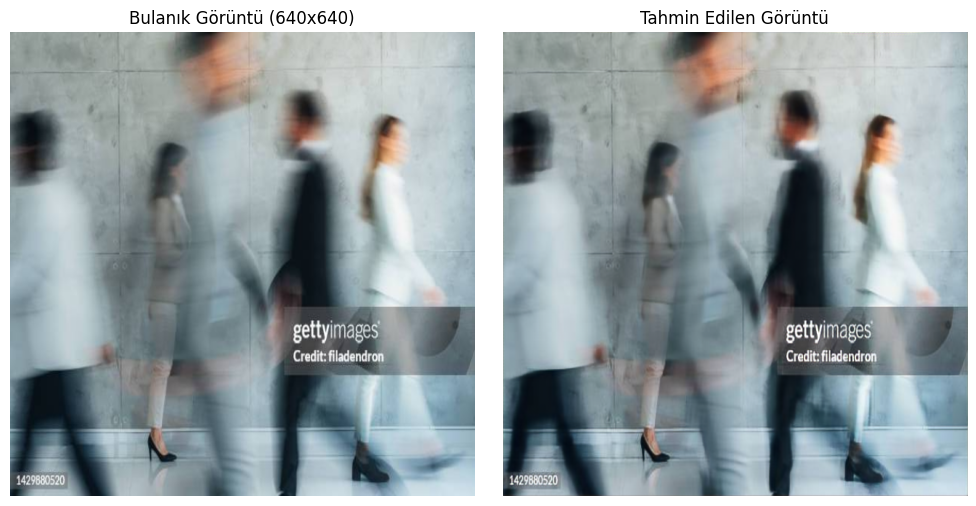

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
import numpy as np

weight_path = '/content/drive/MyDrive/Base_model_with_CBAM_36_epoch.pt'

# Cihaz ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli yükle (UNet modelinin tanımlı olduğunu varsayıyorum)
model = UNet(in_channels=3, num_classes=3).to(device)

# Model ağırlıklarını yükle
try:
    state_dict = torch.load(weight_path, weights_only=True, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
except FileNotFoundError:
    print("Hata: '/content/drive/MyDrive/Base_model_with_CBAM_36_epoch.pt' dosyası bulunamadı!")
    exit(1)
except Exception as e:
    print(f"Hata: Model ağırlıkları yüklenirken bir sorun oluştu: {e}")
    exit(1)

# Görüntüyü yükle
bulanık_img_path = "/content/gettyimages-1429880520-612x612.jpg"  # Bulanık görüntü dosya yolu
try:
    bulanık_img = Image.open(bulanık_img_path).convert("RGB")
except FileNotFoundError:
    print(f"Hata: '{bulanık_img_path}' dosyası bulunamadı!")
    exit(1)

# Dönüşüm tanımla
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Modelin beklediği boyut
    transforms.ToTensor(),          # [0, 1] aralığına çevirir
])

# Görüntüyü tensor'a çevir ve cihaza gönder
bulanık_tensor = transform(bulanık_img).unsqueeze(0).to(device)  # [1, 3, 640, 640]

# Tahmin yap
with torch.no_grad():
    try:
        tahmin = model(bulanık_tensor)
        tahmin_img = tahmin[0].cpu().permute(1, 2, 0).numpy()  # [3, 640, 640] -> [640, 640, 3]
    except Exception as e:
        print(f"Hata: Tahmin sırasında bir sorun oluştu: {e}")
        exit(1)

# Tahmin görüntüsünü [0, 1] aralığına sabitle
# Tahmin edilen görüntü [3, 640, 640] formatında olabilir
tahmin_img = np.clip(tahmin_img, 0, 1)  # Değerleri [0, 1] aralığına sıkıştır

# Eğer modelin çıkışı BGR formatındaysa, bunu RGB'ye çevirebilirsin
# BGR'den RGB'ye dönüşüm
tahmin_img = tahmin_img[..., ::1]  # BGR -> RGB dönüşümü

# Bulanık görüntüyü 640x640 PIL formatına çevir
bulanık_img_resized = transforms.ToPILImage()(bulanık_tensor[0].cpu())

# Görselleştirme
plt.figure(figsize=(10, 5))

# Bulanık görüntü
plt.subplot(1, 2, 1)
plt.title("Bulanık Görüntü (640x640)")
plt.imshow(bulanık_img_resized)
plt.axis("off")

# Tahmin edilen görüntü
plt.subplot(1, 2, 2)
plt.title("Tahmin Edilen Görüntü")
plt.imshow(tahmin_img)
plt.axis("off")

plt.tight_layout()
plt.show()


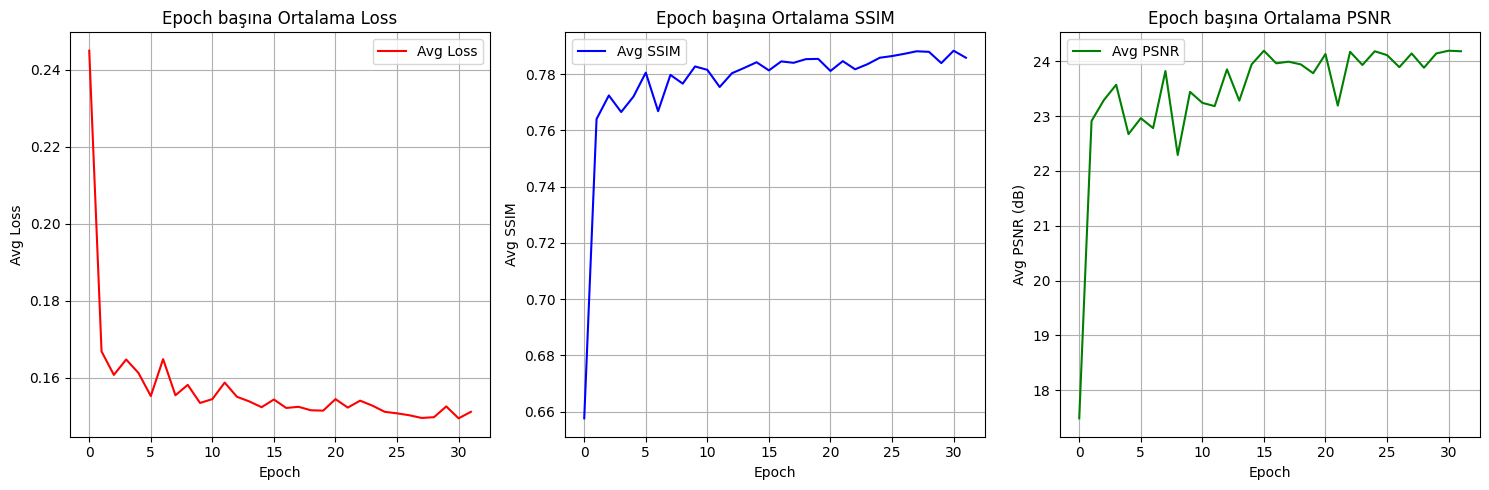

In [ ]:
import matplotlib.pyplot as plt

# Veriler (Test Sonuçları’ndan alındı)
epochs = list(range(32))
avg_loss = [
    0.2450, 0.1668, 0.1607, 0.1647, 0.1612, 0.1552, 0.1648, 0.1554, 0.1581, 0.1534,
    0.1544, 0.1587, 0.1550, 0.1538, 0.1523, 0.1543, 0.1521, 0.1524, 0.1515, 0.1514,
    0.1544, 0.1522, 0.1540, 0.1527, 0.1511, 0.1507, 0.1502, 0.1495, 0.1497, 0.1525,
    0.1494, 0.1511
]
avg_ssim = [
    0.6576, 0.7640, 0.7724, 0.7665, 0.7720, 0.7805, 0.7668, 0.7797, 0.7766, 0.7827,
    0.7815, 0.7754, 0.7803, 0.7822, 0.7842, 0.7813, 0.7845, 0.7840, 0.7853, 0.7854,
    0.7811, 0.7846, 0.7817, 0.7835, 0.7858, 0.7864, 0.7872, 0.7881, 0.7879, 0.7839,
    0.7883, 0.7858
]
avg_psnr = [
    17.49, 22.91, 23.29, 23.57, 22.67, 22.96, 22.78, 23.82, 22.29, 23.44,
    23.24, 23.18, 23.85, 23.28, 23.94, 24.19, 23.96, 23.99, 23.94, 23.78,
    24.13, 23.19, 24.17, 23.93, 24.18, 24.11, 23.89, 24.14, 23.88, 24.14,
    24.19, 24.18
]

# Grafik çizimi
plt.figure(figsize=(15, 5))

# Avg Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, avg_loss, label='Avg Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss')
plt.title('Epoch başına Ortalama Loss')
plt.grid(True)
plt.legend()

# Avg SSIM
plt.subplot(1, 3, 2)
plt.plot(epochs, avg_ssim, label='Avg SSIM', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Avg SSIM')
plt.title('Epoch başına Ortalama SSIM')
plt.grid(True)
plt.legend()

# Avg PSNR
plt.subplot(1, 3, 3)
plt.plot(epochs, avg_psnr, label='Avg PSNR', color='green')
plt.xlabel('Epoch')
plt.ylabel('Avg PSNR (dB)')
plt.title('Epoch başına Ortalama PSNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()